In [52]:
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
from pandas.tools.plotting import table



In [53]:
Location = 'Stepping from 10-20-30-40-50-60-10 RH 7 min on 15 min off.TimeSeries'
df = pd.read_csv(Location, sep = '\t', header = 4)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12801 entries, 0 to 12800
Data columns (total 3 columns):
Date                              12801 non-null object
Elapsed Time                      12801 non-null float64
Reflection(Percent reflection)    12801 non-null float64
dtypes: float64(2), object(1)
memory usage: 300.1+ KB
None


,Date,Elapsed Time,Reflection(Percent reflection)
0,13:31:00.578,0.000000,25.246
1,13:31:01.578,0.997965,24.993
2,13:31:02.578,1.995974,25.528
3,13:31:03.578,2.994943,25.343
4,13:31:04.578,3.993006,25.285


In [54]:
df.tail()

,Date,Elapsed Time,Reflection(Percent reflection)
12796,17:06:02.187,12901.88819,25.509
12797,17:06:03.203,12902.89865,25.703
12798,17:06:04.203,12903.89764,25.596
12799,17:06:05.203,12904.89557,25.353
12800,17:06:06.265,12905.97061,25.324


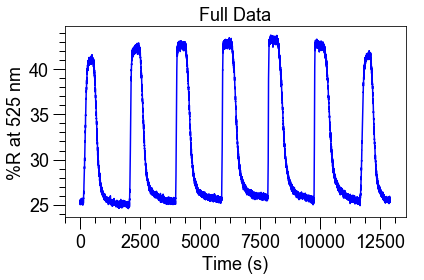

In [55]:
def plotter(title, data):

    "This function plots the x-data 'Elapsed Time' and y-data Reflection(Percent reflection) \
    in a dataframe == data. Give the figure a title with the string 'title'"
    
    #extract the data from the dataframe 'data'
    x = data['Elapsed Time']
    y = data['Reflection(Percent reflection)']
    
    #set up the axis subplot in the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y, color ='b')
    
    #customizing the figure 
    ax.tick_params(axis='both', labelsize=16, length = 12, width = 1)
    ax.tick_params(axis = 'both', which = 'minor', length = 6, width = 1)
    ax.set_title(title, fontsize = 18, fontname = 'Arial')
    ax.set_xlabel("Time (s)", fontname = 'Arial', fontsize = 18)
    ax.set_ylabel("%R at 525 nm", fontsize = 18, fontname = 'Arial')
    plt.minorticks_on()
    plt.xticks(fontname = 'Arial', fontsize = 18)
    plt.yticks(fontname = 'Arial', fontsize = 18)
    plt.tight_layout()
    #show the plot
    plt.show()
        
plotter('Full Data', df)

# I want to extract just the rising portions of the data above

In [56]:
def growth_extract(dataframe, start, length, delta, n):
    '''This function extracts the rise portion of the data(dataframe), starting from time == 'start', with a \
    lenght == 'lenght' and period == delta. n is a factor for naming the keys of the dictionary. Returns a \
    a dictionary of dataframes with a just the rise portion of the data.'''
    
    NewDataFrameNames = [str(_) + '% RH' for _ in range(10, n*10, 10)]+['10% RH_repeat']
    DFD = {elem : pd.DataFrame for elem in NewDataFrameNames}
    for key in DFD.keys():
        DFD[key] = dataframe[(dataframe['Elapsed Time']>=start) & (dataframe['Elapsed Time']<=(start+length))]
        start += delta
    return DFD

DFD = growth_extract(df, 120, 420, 1920, 7)

# Let's lot these to see what they look like.

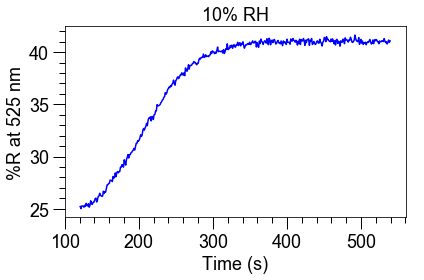

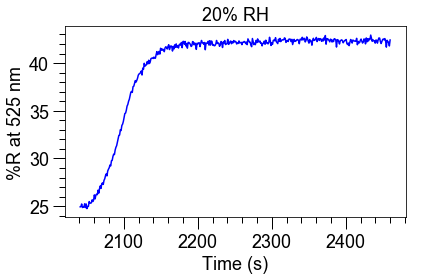

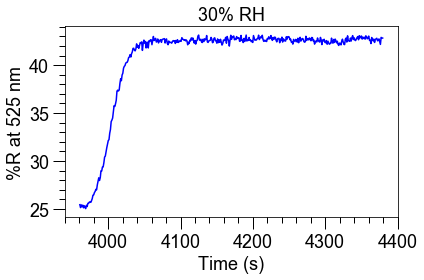

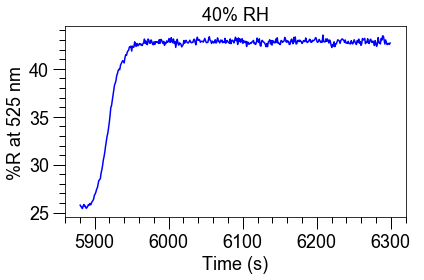

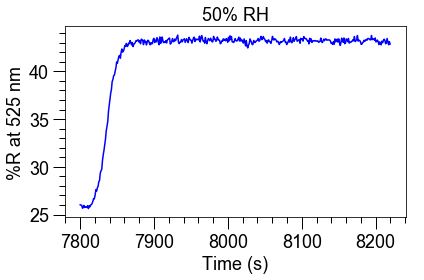

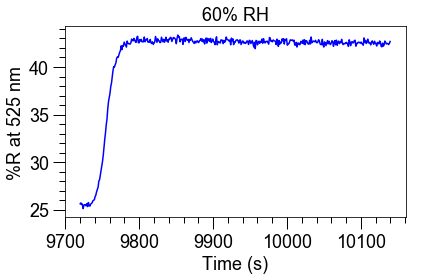

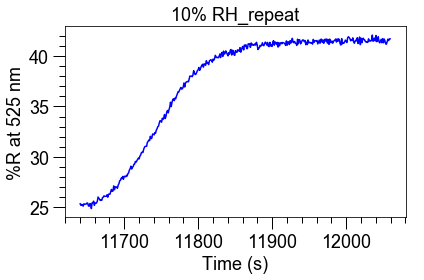

In [57]:
for (keys, values) in DFD.items():
    plotter(keys, values)

# Now, I will normalize these segments so they all start at time = 0 sec

In [58]:
def normalize(datadict):
    '''Takes a dictionary of dataframes with x axis in seconds and normalizes them to all start \ 
    at time == 0. Returns a dictionary of normalized dataframes. Keys are the same as the oringinal \
    dictionary of dataframes.'''
    
    #set x-axis with normalized value
    key_list = list(datadict.keys())
    # a list of the first x value in the 'Elapsed Time' Column for each dataframe in 
    # the dataframe dictionary, datadict
    normalized_starts = [datadict[key].iloc[0,1] for key in key_list]
    x_normvalues = zip(key_list, normalized_starts)
    x_list = [datadict[x]['Elapsed Time'] - y for x,y in x_normvalues]
    
    # set y data with list of Elapsed Time from dataframedict
    y_list = [y_data['Reflection(Percent reflection)'] for y_data in datadict.values()]
    data = zip(x_list, y_list)
    newDFL = [pd.concat([x,y], axis =1) for x,y in data]

    #zip up keys and the normalized data list
    key_DF = zip(datadict.keys(), newDFL)
    normalized_DFD = {x: y for x,y in key_DF}
    return normalized_DFD

normalizedDFD = normalize(DFD)

# Which makes it easy to plot them all together.

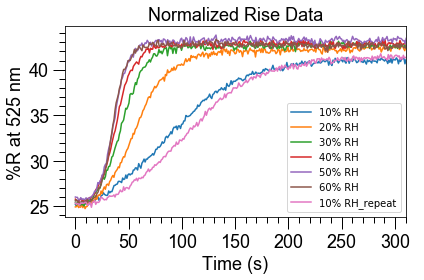

In [59]:
def combined_plotter(datadict, title):
    
    #make a single axes in a figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #iterate through dataframe dictionary to get the desired data and label it
    for key in datadict.keys():
        ax.plot(datadict[key]['Elapsed Time'], datadict[key]['Reflection(Percent reflection)'], label= key)
        
    
    #customizing the figure 
    ax.set_xlim(-10, 310)
    ax.tick_params(axis='both', labelsize=16, length = 12, width = 1)
    ax.tick_params(axis = 'both', which = 'minor', length = 6, width = 1)
    ax.set_title(title, fontsize = 18, fontname = 'Arial')
    ax.set_xlabel("Time (s)", fontname = 'Arial', fontsize = 18)
    ax.set_ylabel("%R at 525 nm",fontsize = 18, fontname = 'Arial')
    plt.minorticks_on()
    plt.xticks(fontname = 'Arial', fontsize = 18)
    plt.yticks(fontname = 'Arial', fontsize = 18)
    plt.legend(loc='best')
    #still need to change the font of the legend to Arial
    plt.tight_layout()
    #show the plot
    plt.show()
    
combined_plotter(normalizedDFD, 'Normalized Rise Data')

# I want to now find the points of these lines (time, %R) where %R is half the saturation value.

In [60]:
def halfsat_valueandtime(dataframedict):
    # set y data with list of Elapsed Time from dataframedict
    y_list = [df['Reflection(Percent reflection)'] for df in dataframedict.values()]

    # create a list of all the half saturation points for all calculate the 
    half_sat  = [(y[-300:].mean() + float(y.values[0]))/2 for y in y_list]
    
    
    # zip together keys and half sat list to put into a new dictionary
    blah = zip(dataframedict.keys(), half_sat)
    half_sat_dict = {x:y for x,y in blah}
    

    # creating a list of the seven closest 
    list_of_closevalues = [dataframedict[key].iloc[(dataframedict[key]\
        ['Reflection(Percent reflection)']-half_sat_dict[key]).\
        abs().argsort()[:7]] for key in dataframedict.keys()]
    
    
    half_sat_time = [list_of_closevalues[x]['Elapsed Time'].mean() for x in range(len(list_of_closevalues))]
   
    half_sat_time_std = [list_of_closevalues[x]['Elapsed Time'].std() for x in range(len(list_of_closevalues))]

    results = DataFrame({'Half Saturation Value (%R)': half_sat, \
                         'Half Saturation Time (s)': half_sat_time, \
                         'Half Saturation Time Std (s)': half_sat_time_std}, \
                        columns = ['Half Saturation Value (%R)', 'Half Saturation Time (s)', 'Half Saturation Time Std (s)'],\
                        index = list(dataframedict.keys()))
    return results

results = halfsat_valueandtime(normalizedDFD)
print(results)

               Half Saturation Value (%R)  Half Saturation Time (s)  \
10% RH                          32.795020                 87.648096   
20% RH                          33.567098                 56.301617   
30% RH                          34.029660                 44.442816   
40% RH                          34.302040                 39.310631   
50% RH                          34.620312                 36.243148   
60% RH                          34.132262                 35.276429   
10% RH_repeat                   32.893188                103.868214   

               Half Saturation Time Std (s)  
10% RH                             2.160124  
20% RH                             2.192159  
30% RH                             2.413962  
40% RH                             2.180623  
50% RH                             2.192169  
60% RH                             2.163600  
10% RH_repeat                      2.156629  


# I realized I didn't want to have to transcribe the results to a table. So I created a make table function to put all the results into a table.

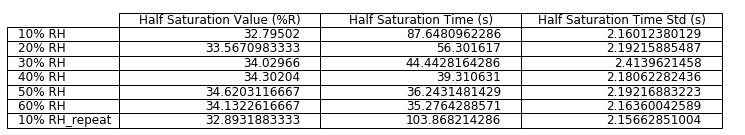

In [61]:
def maketable(df):
    fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(ax, df, loc='upper right', colWidths=[0.25]*len(df.columns))  # where df is your data frame
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    tabla.scale(1.2, 1.2) # change size table
    
    plt.show()
    
    
maketable(results)